In [1]:
import sys
import math
import numpy as np
from numpy import pi, sqrt, inf, log
from ecell4 import *

L = 100
voxel_radius = 0.005
D = 1
rng = GSLRandomNumberGenerator()
rng.seed(1)
#if len(sys.argv) > 1:
#    rng.seed(int(sys.argv[1]))

w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxel_radius, Integer3(3, 3, 3), rng)

def singlerunA(dt, Pacc,alpha):
    assert Pacc*alpha  <= 1
    assert alpha<=1

    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)

    dt = dt*alpha
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and nsteps < maxstep:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc * alpha >= w.rng().uniform(0, 1):
                return t
        elif alpha >= w.rng().uniform(0, 1):
            coord2 = newcoord
        t += dt
        nsteps += 1
    return False

def singlerun(dt, Pacc):
    assert Pacc<= 1
    coord1 = w.position2coordinate(ones() * L * 0.5)
    coord2 = w.get_neighbor(coord1, 0)

    dt = dt
    t, nsteps = 0.0, 0
    while all(0 <= dim < L for dim in w.coordinate2position(coord2)) and nsteps < maxstep:
        rnd = w.rng().uniform_int(0, 11)
        newcoord = w.get_neighbor(coord2, rnd)
        if newcoord == coord1:
            if Pacc >= w.rng().uniform(0, 1):
                return t
        else:
            coord2 = newcoord
            nsteps += 1
        t += dt
    return False

        
kD = 4 * pi * (2 * voxel_radius) * D
ka_factor = 10  # 100.0
ka = kD * ka_factor
r0=0.256318
Pacc = Pacc = (1./r0-1)*ka_factor#ka / (6 * sqrt(2) * D * voxel_radius)
dt = (4 * voxel_radius * voxel_radius) / (6 * D)
maxstep= 1000000
ntrials = 10000
print Pacc
if Pacc<=1:
    res = [singlerun(dt, Pacc) for _ in range(ntrials)]
else:    
    res = [singlerunA(dt, Pacc,0.1/Pacc) for _ in range(ntrials)]
times = np.array([i for i in res if i != False])
#print float(len(times))/ntrials
#print float(len(times[times<dt]))/ntrials

29.0140372506


In [19]:
def phix(x):
    return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def f(t):
    x = np.sqrt(t)
    return (1./math.pi**0.5 /x - phix(x))

def theory(c):
    R = 2*voxel_radius
    tmol = R*R/D/(1+ka/kD)**2
    Ptotal = ka/(ka+kD)
    tau = np.logspace(-2,math.log10(1e-1/tmol),100)
    #tau = np.logspace(0,math.log10(1e-1/tmol),100)
    t = tau*tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(t,f(tau)*Nfactor,'-',c=c)#,label='factor'+str(factor))
    #plt.plot([tmol]*10, np.logspace(-10,4,10),'--')
    return #t,Ptotal*f(tau)

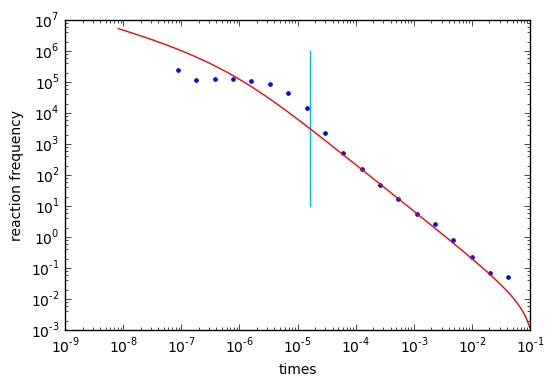

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
hist, bin_edges = np.histogram(times,bins=np.logspace(np.log10(min(times)),np.log10(max(times)),20))
tt = 0.5*(bin_edges[:-1]+bin_edges[1:])
binwid = -(bin_edges[:-1]-bin_edges[1:])
ft = np.array([float(h)/ntrials/b for h,b in zip(hist,binwid)])
plt.loglog(tt,ft,'.')
z = lambda x: 1e-4*(x**-1.5) #t^(-0.5)
w = lambda x: 1e2*(x**-0.5) #t^(-0.5)
#plt.plot(np.logspace(-5,-2,50),z(np.logspace(-5,-2,50)),label='p ~ t^-1.5')
#plt.plot(np.logspace(-8,-5,50),w(np.logspace(-8,-5,50)),'r',label='p ~ t^-0.5')
prange = np.logspace(1,6,10)
plt.plot([dt]*len(prange),prange,'c')
plt.xlabel('times')
plt.ylabel('reaction frequency')
#totalsum = sum(ft*binwid)
theory('r')
plt.legend()


In [30]:
name = "rebinding_prob_kfac10"
fn = open(name,'w')
np.savetxt(name,np.column_stack((tt,ft)),delimiter=',')
fn.close()